# Digit Classification using Dense Neural Network

MNIST is a dataset of handwriting digits and we are going to be building dense neural networks (also known as fully connected networks) from scratch that can classify these images. 

Each image has 28x28=784 pixels. Each pixel is between 0 (white) to 255 (black)

## Two-layer Neural Network

We will start by building a 2 layer neural network then slowly work our way to build more layers / modify hyper-parameters / implement different activation or initialization functions\
ReLU activation function for hidden layers and softmax activation function for output layer

In [1]:
# First import the relevant libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

import pickle

In [2]:
# import the dataset
digit=pd.read_csv('train.csv')

# Get the preview
digit.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
m,n=digit.shape
digit.shape

(42000, 785)

Text(0.5, 1.0, 'Number of digit classes')

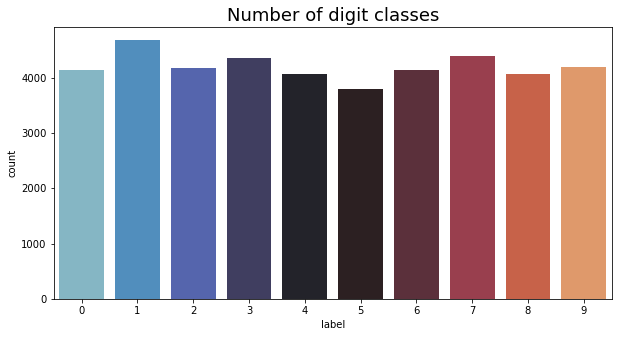

In [68]:
plt.figure(figsize=(10,5))
sb.countplot(x=digit['label'], palette='icefire')
plt.title('Number of digit classes', fontsize=18)

In [4]:
# Change to numpy array
digit=np.array(digit)
m,n = digit.shape # m is the number of rows, n is the number of columns
np.random.shuffle(digit)

# Split into training and testing dataset, 
# Transpose the matrix such that each column is one example, and can be supplied to the input layer
digit_test=digit[0:1000].T
y_test=digit_test[0] # Labels are now in the first row
x_test=digit_test[1:n] # Pixel 1 to 784 are from the second row onwards
x_test=x_test/255. # Standardise the dataset

digit_train=digit[1000:m].T
y_train=digit_train[0]
x_train=digit_train[1:n]
x_train=x_train/255. # Performs normalization to scale pixel values to the range of 0 to 1
_,m_train=x_train.shape

In [5]:
# View shape of first column
x_train[:,0].shape

(784,)

In [8]:
# Function to define the weights and bias
def init_params():
    W1=np.random.rand(10,784)-0.5 # Generates a 10x784 array of random numbers between -0.5 and 0.5
    b1=np.random.rand(10,1)-0.5 
    W2=np.random.rand(10,10)-0.5
    b2=np.random.rand(10,1)-0.5
    return W1,b1,W2,b2

# Define Rectified Linear Unit
def ReLU(Z):
    return np.maximum(Z,0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(W1,b1,W2,b2,X):
    Z1=W1.dot(X)+b1 # Value for first layer
    A1=ReLU(Z1) # Activation function for first layer
    
    Z2=W2.dot(A1)+b2 # Value for second layer
    A2=softmax(Z2) # Activation function for second layer

    return Z1,A1,Z2,A2

# Convert output values as a single-column matrix with 10 rows, each corresponding to the possible digits 0-9
def one_hot(Y):
    one_hot_Y=np.zeros((Y.size, Y.max()+1))
    one_hot_Y[np.arange(Y.size),Y]=1 # Match where the 1s are at
    one_hot_Y=one_hot_Y.T # Transpose to get each column as an example
    return one_hot_Y

# Derivative of ReLU function
def deriv_ReLU(Z):
    return Z > 0

# Backpropagation to compute gradients of loss with respect to the weights and biases 
def back_prop(Z1,A1,Z2,A2,W2,X,Y):
    m=len(Y)
    one_hot_Y=one_hot(Y)
    dZ2=A2-one_hot_Y
    dW2=1 / m * dZ2.dot(A1.T) # Divide by m to find the average
    db2=1 / m * np.sum(dZ2)
    dZ1=W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1=1 / m * dZ1.dot(X.T)
    db1=1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

# Use gradient descent to optimise the values of weights and biases to improve predictions
def update_params(W1,b1,W2,b2,dW1,db1,dW2,db2,alpha): # alpha is user-defined learning rate
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1,b1,W2,b2
    

In [20]:
def get_predictions(A2):
    return np.argmax(A2,0) # Finds the class with the highest number

def get_accuracy(predictions, Y):
    return np.sum(predictions==Y)/Y.size

# Find the derivative and slowly move towards the point of minimum gradient which means cost is a minimum
def gradient_descent(X,Y, iterations,alpha):
    W1,b1,W2,b2=init_params()
    accuracy=[]
    for i in range(iterations):
        Z1,A1,Z2,A2=forward_prop(W1,b1,W2,b2,X)
        dW1, db1, dW2, db2=back_prop(Z1,A1,Z2,A2,W2,X,Y)
        W1,b1,W2,b2=update_params(W1,b1,W2,b2,dW1,db1,dW2,db2,alpha)
        accuracy.append(get_accuracy(get_predictions(A2), Y))
        if i%10 ==0: # Print accuracy for every 10 iterations
            print("Iteration: ", i)
            print("Accuracy: ", accuracy[-1])
    predictions=get_predictions(A2)
    return W1,b1,W2,b2,accuracy, predictions

In [27]:
W1,b1,W2,b2,accuracy,predictions=gradient_descent(x_train,y_train,500,0.1)

Iteration:  0
Accuracy:  0.09907317073170732
Iteration:  10
Accuracy:  0.1662439024390244
Iteration:  20
Accuracy:  0.23429268292682928
Iteration:  30
Accuracy:  0.3008048780487805
Iteration:  40
Accuracy:  0.3521951219512195
Iteration:  50
Accuracy:  0.4002439024390244
Iteration:  60
Accuracy:  0.44539024390243903
Iteration:  70
Accuracy:  0.48360975609756096
Iteration:  80
Accuracy:  0.5159024390243903
Iteration:  90
Accuracy:  0.5479268292682927
Iteration:  100
Accuracy:  0.5817560975609756
Iteration:  110
Accuracy:  0.6119756097560975
Iteration:  120
Accuracy:  0.6367804878048781
Iteration:  130
Accuracy:  0.6571463414634147
Iteration:  140
Accuracy:  0.6721463414634147
Iteration:  150
Accuracy:  0.6848536585365854
Iteration:  160
Accuracy:  0.6965853658536585
Iteration:  170
Accuracy:  0.7067073170731707
Iteration:  180
Accuracy:  0.7160731707317073
Iteration:  190
Accuracy:  0.7251219512195122
Iteration:  200
Accuracy:  0.7325853658536585
Iteration:  210
Accuracy:  0.740341463414

In [13]:
# Plot accuracy graph
def plot_accuracy(accuracy, iterations):
    plt.figure(figsize=(7,5))
    xaxis=[i+1 for i in range(iterations)] 
    sb.lineplot(x=xaxis,y=accuracy, color="purple")
    plt.xlabel('Number of iterations', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.title('Training Accuracy', fontsize=20)
    plt.show

Accuracy on Training Set:  0.8367073170731707


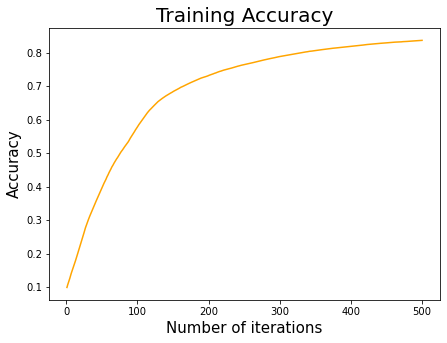

In [65]:
print("Accuracy on Training Set: ", accuracy[-1])
plot_accuracy(accuracy, 500)

In [36]:
# Get classification report
def get_classification(Y, predictions):
    class_labels=[str(i) for i in range(10)]
    report = classification_report(Y, predictions,target_names=class_labels)
    print(report)

In [33]:
get_classification(y_train,predictions)

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      4046
           1       0.92      0.96      0.93      4565
           2       0.85      0.83      0.84      4089
           3       0.83      0.83      0.83      4240
           4       0.82      0.83      0.82      3976
           5       0.80      0.69      0.74      3709
           6       0.88      0.88      0.88      4042
           7       0.87      0.86      0.86      4293
           8       0.71      0.77      0.74      3949
           9       0.76      0.76      0.76      4091

    accuracy                           0.84     41000
   macro avg       0.84      0.83      0.83     41000
weighted avg       0.84      0.84      0.84     41000



In [14]:
# Bar plot to illustrate the results
def plot_bar(Y, predictions):
    color_map={True:'green', False:'red'}
    
    # Keep track of correct and incorrect predictions
    correct_counts=np.zeros(10)
    incorrect_counts=np.zeros(10)
    for actual,predicted in zip(Y, predictions):
        if actual==predicted:
            correct_counts[actual]+=1
        else:
            incorrect_counts[actual]+=1
    categories=[i for i in range(10)]
    width=0.60
    fig,ax=plt.subplots(figsize=(9,7))
    rect1=ax.bar(categories, correct_counts,width, color=color_map[True], label='Correct')
    rect2=ax.bar(categories, incorrect_counts,width, color=color_map[False], label='Incorrect')
    
    # Set labels and title
    ax.set_xlabel('Labels',fontsize=15)
    ax.set_ylabel('Count', fontsize=15)
    ax.set_title('Correct and Incorrect Predictions by Labels', fontsize=20)
    ax.set_xticks(categories)
    ax.set_xticklabels(categories)
    ax.legend()
    
    plt.show()

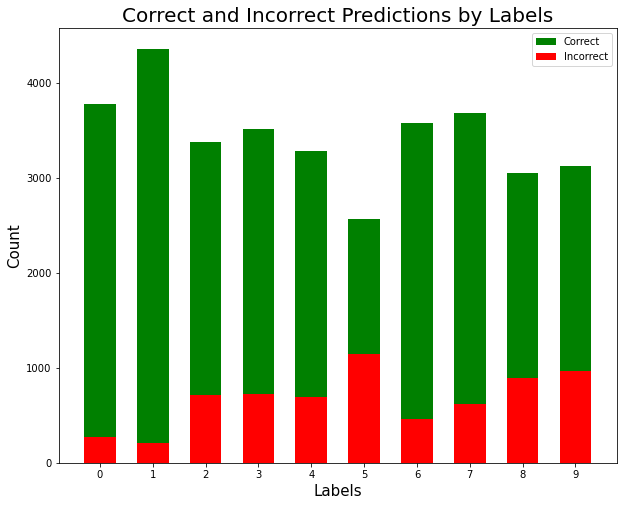

In [43]:
plot_bar(y_train, predictions)

In [20]:
# Plot confusion matrix because it's cool :)
def plot_confusion(Y, predictions):
    labels=[i for i in range(10)]
    cm=confusion_matrix(Y, predictions)
    plt.figure(figsize=(10,8))
    sb.heatmap(cm,annot=True,fmt='.0f', linecolor='gray', cmap='rainbow', yticklabels=labels,xticklabels=labels)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('Actual Labels', fontsize=12)
    plt.title('Confusion Matrix for Training', fontsize=18)
    
    # Show all ticks and label them
    ticks=np.arange(10)
    plt.xticks(ticks)
    plt.yticks(ticks)
                    
    plt.show()

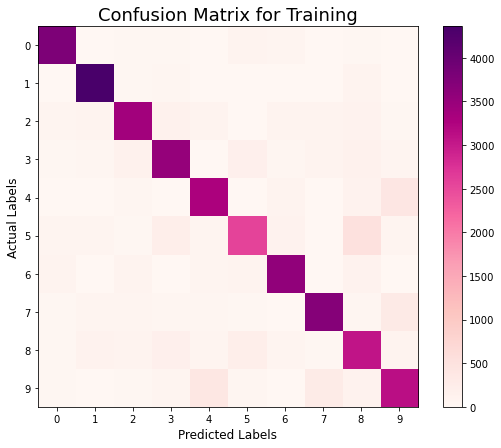

In [55]:
plot_confusion(y_train,predictions)

In [60]:
# Functions to make predictions
def make_predictions(X,W1,b1,W2,b2):
    _,_,_,A2=forward_prop(W1,b1,W2,b2,X)
    predictions=get_predictions(A2)
    return predictions

# Predict on test set
def test_prediction(index, W1,b1,W2,b2):
    current_image=x_train[:,index,None]
    prediction=make_predictions(x_train[:,index,None],W1,b1,W2,b2)
    label=y_train[index]
    print('Index: ', index)
    print("Model prediction: ", prediction)
    print("Actual Label: ", label)
    
    # Display the image
    current_image=current_image.reshape((28,28))
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()  

Index:  0
Model prediction:  [2]
Actual Label:  2


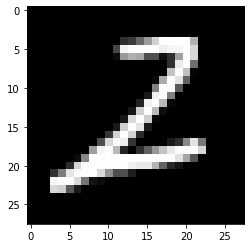

Index:  1534
Model prediction:  [7]
Actual Label:  7


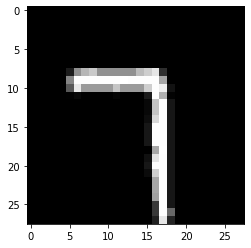

In [62]:
# Test on a couple of examples
test_prediction(0,W1,b1,W2,b2)
test_prediction(1534,W1,b1,W2,b2)

In [64]:
# Find accuracy of the test set
y_pred=make_predictions(x_test,W1,b1,W2,b2)
print("Accuracy on Test Set: " ,get_accuracy(y_pred, y_test))

Accuracy on Test Set:  0.841


In [87]:
# Now let's try with the new unseen data
def kaggle_test(W1,b1,W2,b2):
    testset=pd.read_csv('test.csv')
    # Transpose the matrix such that each column is one image, and can be supplied to the input layer
    testset_x=testset.T/255. # Normalize the dataset

    # Get accuracy of model's predictions on new, unseen data
    testset_pred=make_predictions(testset_x,W1,b1,W2,b2)
    
    # Create dataframe for submission on Kaggle
    imageid=[i+1 for i in range(28000)]
    data={'ImageId': imageid, 
          'Label': testset_pred.tolist()}
    final=pd.DataFrame(data)
    final.to_csv('submission.csv', index=False)
    
kaggle_test(W1,b1,W2,b2)

**Submission #1\
Accuracy : 0.8371\
Not bad for a simple neural network! Now let's include more layers and try to make the model better!**

## Three-layer Neural Network

Let's add another hidden layer which can increase the model's capacity to learn complex patterns and relationships. Deeper networks can generalize better to unseen data.\

ReLU for hidden layers, softmax for output layer\
First trial: first hidden layer as the same number of nodes as the second hidden layer\

We will make some adjustments to optimise the model along the way

In [24]:
# Now we have 3 weights and biases
def init_params1():
    W1=np.random.rand(10,784)-0.5 # Generates a 10x784 array of random numbers between -0.5 and 0.5
    b1=np.random.rand(10,1)-0.5 
    W2=np.random.rand(10,10)-0.5
    b2=np.random.rand(10,1)-0.5
    W3=np.random.rand(10,10)-0.5 # Same size as W2
    b3=np.random.rand(10,1)-0.5
    return W1,b1,W2,b2,W3,b3

def forward_prop1(W1,b1,W2,b2,W3,b3,X):
    Z1=W1.dot(X)+b1
    A1=ReLU(Z1) # First layer
    
    Z2=W2.dot(A1)+b2
    A2=ReLU(Z2) # Second layer
    
    Z3=W3.dot(A2)+b3
    A3=softmax(Z3) # Third layer
    
    return Z1,A1,Z2,A2,Z3,A3

def back_prop1(Z1,A1,Z2,A2,Z3,A3,W2,W3,X,Y):
    m=len(Y)
    one_hot_Y=one_hot(Y)
    dZ3=A3-one_hot_Y
    dW3=1 / m * dZ3.dot(A2.T)
    db3=1 / m * np.sum(dZ3)
    dZ2=W3.T.dot(dZ3) * deriv_ReLU(Z2)
    dW2=1 / m * dZ2.dot(A1.T)
    db2=1 / m * np.sum(dZ2)
    dZ1=W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1=1 / m * dZ1.dot(X.T)
    db1=1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2, dW3, db3

def update_params1(W1,b1,W2,b2,W3,b3,dW1,db1,dW2,db2,dW3,db3,alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    W3 = W3 - alpha * dW3
    b3 = b3 - alpha * db3
    return W1,b1,W2,b2,W3,b3

def gradient_descent1(X,Y,iterations,alpha):
    W1,b1,W2,b2,W3,b3=init_params1()
    accuracy=[]
    for i in range(1,iterations+1):
        Z1,A1,Z2,A2,Z3,A3=forward_prop1(W1,b1,W2,b2,W3,b3,X)
        dW1,db1,dW2,db2,dW3,db3=back_prop1(Z1,A1,Z2,A2,Z3,A3,W2,W3,X,Y)
        W1,b1,W2,b2,W3,b3=update_params1(W1,b1,W2,b2,W3,b3,dW1,db1,dW2,db2,dW3,db3,alpha)
        accuracy.append(get_accuracy(get_predictions(A3), Y))
        if i%10 ==0: # Print accuracy for every 10 iterations
            print("Iteration: ", i)
            print("Accuracy: ", accuracy[-1])
    predictions=get_predictions(A3)
    return W1,b1,W2,b2,W3,b3,accuracy, predictions

In [98]:
W1,b1,W2,b2,W3,b3,accuracy1,predictions1=gradient_descent1(x_train,y_train,500,0.1)

Iteration:  10
Accuracy:  0.15729268292682927
Iteration:  20
Accuracy:  0.21536585365853658
Iteration:  30
Accuracy:  0.278609756097561
Iteration:  40
Accuracy:  0.3651951219512195
Iteration:  50
Accuracy:  0.41473170731707315
Iteration:  60
Accuracy:  0.45221951219512196
Iteration:  70
Accuracy:  0.4973170731707317
Iteration:  80
Accuracy:  0.5361707317073171
Iteration:  90
Accuracy:  0.5636097560975609
Iteration:  100
Accuracy:  0.5892682926829268
Iteration:  110
Accuracy:  0.6097317073170732
Iteration:  120
Accuracy:  0.6292682926829268
Iteration:  130
Accuracy:  0.646609756097561
Iteration:  140
Accuracy:  0.6621951219512195
Iteration:  150
Accuracy:  0.6741951219512196
Iteration:  160
Accuracy:  0.6871219512195123
Iteration:  170
Accuracy:  0.6970731707317073
Iteration:  180
Accuracy:  0.7061463414634146
Iteration:  190
Accuracy:  0.7142926829268292
Iteration:  200
Accuracy:  0.7215853658536585
Iteration:  210
Accuracy:  0.7277073170731707
Iteration:  220
Accuracy:  0.733536585365

Accuracy on Training Set:  0.8120975609756098


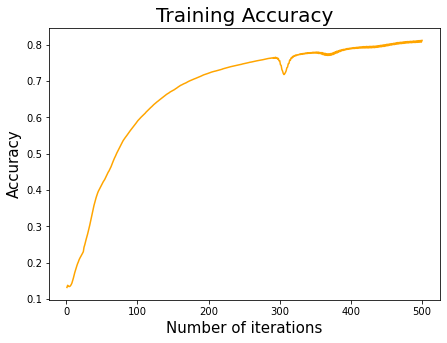

In [99]:
# Plot accuracy graph
print("Accuracy on Training Set: ", accuracy1[-1])
plot_accuracy(accuracy1,500)

We noticed some drops in accuracy (~300 and ~350) but let's continue to try it on the test set

In [100]:
# Get classification report
get_classification(y_train, predictions1)

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      4045
           1       0.92      0.95      0.93      4584
           2       0.83      0.82      0.82      4071
           3       0.85      0.68      0.76      4253
           4       0.79      0.85      0.81      3972
           5       0.72      0.66      0.69      3696
           6       0.81      0.87      0.84      4033
           7       0.89      0.87      0.88      4298
           8       0.67      0.77      0.72      3966
           9       0.77      0.72      0.74      4082

    accuracy                           0.81     41000
   macro avg       0.81      0.81      0.81     41000
weighted avg       0.81      0.81      0.81     41000



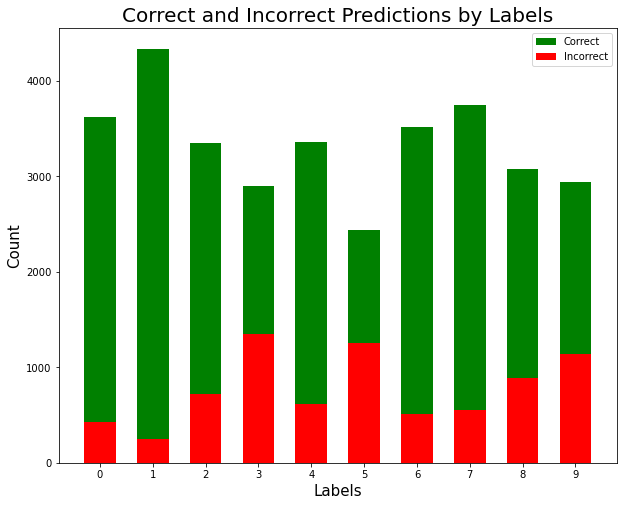

In [101]:
# Bar plot to illustrate the results
plot_bar(y_train, predictions1)

We observed more incorrect predictions for the number 5, same problem as the 2 layer neural network

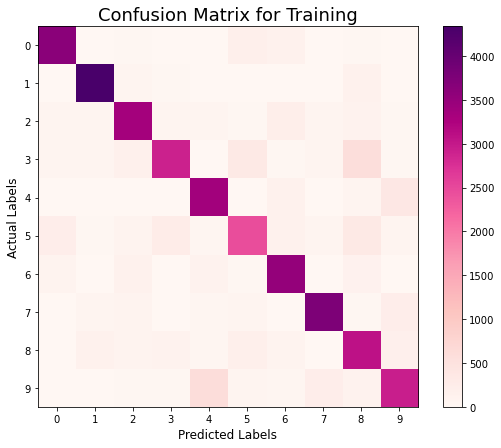

In [102]:
# Confusion matrix to illustrate the results 
plot_confusion(y_train,predictions1)

In [62]:
# Function to make predictions
def make_predictions1(X,W1,b1,W2,b2,W3,b3):
    _,_,_,_,_,A3=forward_prop1(W1,b1,W2,b2,W3,b3,X)
    predictions=get_predictions(A3)
    return predictions

In [104]:
# Find accuracy of test set
y_pred=make_predictions1(x_test,W1,b1,W2,b2,W3,b3)
print("Accuracy on Test Set: ", get_accuracy(y_pred,y_test))

Accuracy on Test Set:  0.803


In [6]:
# Implementing together with K-folds cross-validation
def GDwKFold(k,iterations,alpha):
    accuracy=[]
    itv=int(42000/k)
    for j in range(k):
        start=j*itv
        end=(j+1)*itv
        digit_test=digit[start:end].T
        y_test=digit_test[0]
        x_test=digit_test[1:785]
        x_test=x_test/255.
        
        digit_train=np.concatenate((digit[:start], digit[end:]), axis=0).T
        y_train=digit_train[0]
        x_train=digit_train[1:785]
        x_train=x_train/255.
        
        W1,b1,W2,b2,W3,b3=init_params1()
        for i in range(1,iterations+1):
            Z1,A1,Z2,A2,Z3,A3=forward_prop1(W1,b1,W2,b2,W3,b3,x_train)
            dW1,db1,dW2,db2,dW3,db3=back_prop1(Z1,A1,Z2,A2,Z3,A3,W2,W3,x_train,y_train)
            W1,b1,W2,b2,W3,b3=update_params1(W1,b1,W2,b2,W3,b3,dW1,db1,dW2,db2,dW3,db3,alpha)
        accuracy.append(get_accuracy(make_predictions1(x_test,W1,b1,W2,b2,W3,b3), y_test))
    return accuracy

In [121]:
kfold_accuracy=GDwKFold(5,500,0.1)

Mean Accuracy with K-Fold Cross Validation:   0.8049523809523809


<AxesSubplot:title={'center':'Cross-Validation Results'}, ylabel='Accuracy'>

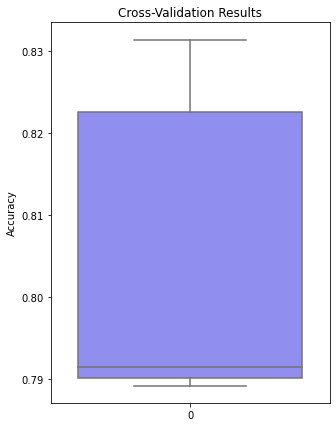

In [124]:
# Find mean accuracy and illustrate results
print("Mean Accuracy with K-Fold Cross Validation:  ",np.average(kfold_accuracy))
plt.figure(figsize=(5,7))
plt.ylabel("Accuracy")
plt.title("Cross-Validation Results", fontsize=12)
sb.boxplot(data=kfold_accuracy, palette='cool')

Accuracy for both train and test datasets dropped when we increase the number of hidden layers by 1. One reason could be: 

- Vanishing or Exploding Gradients: During backpropagation, gradients can become extrememly small or large as they propagate through each layer, making it difficult for the network to update the weights and biases effectively. This hinders the training process and result in suboptimal performance 

Possible ways to resolve this issue: 

- Initialization: Initialize the weights and biases properly using techniques like Xavier or He initialization to ensure that the initial weights and biases are appropriate
- Network Design: Use techniques like residual connections or skip connections to help train deeper networks more effectively

### Varying the learning rates
Experimenting with different learning rates can help find the optimal learning rate profile for a specific problem

In [37]:
# List to keep track of learning rates and their corresponding accuracies
learning_rates=[]
accuracy=[]

### Learning rate = 0.01

In [38]:
# Learning rate of 0.05
W1,b1,W2,b2,W3,b3,accuracy1,predictions1=gradient_descent1(x_train,y_train,500,0.01)

Accuracy on Training Set:  0.4775121951219512


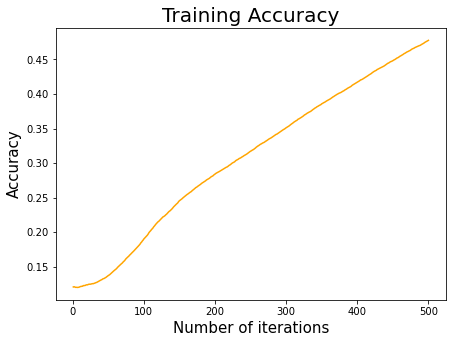

In [39]:
# Append to list
learning_rates.append(0.01)
accuracy.append(accuracy1[-1])

# Plot accuracy graph
print("Accuracy on Training Set: ", accuracy1[-1])
plot_accuracy(accuracy1,500)

Sluggish graph shows that the training process is too slow for it to converge to an optimal solution. This is because with a small learning rate, the model updates it parametrs very gradually, thus it will take a longer time to converge to an acceptable solution. 

### Learning rate = 0.05

In [40]:
# Learning rate of 0.05
W1,b1,W2,b2,W3,b3,accuracy1,predictions1=gradient_descent1(x_train,y_train,500,0.05)

Accuracy on Training Set:  0.6354146341463415


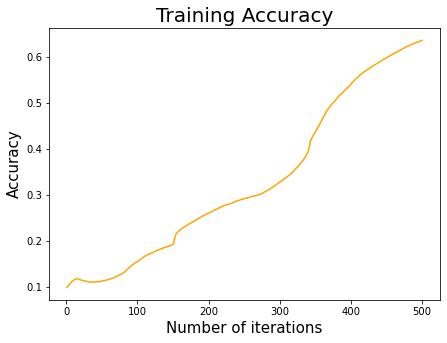

In [41]:
# Append to list
learning_rates.append(0.05)
accuracy.append(accuracy1[-1])

# Plot accuracy graph
print("Accuracy on Training Set: ", accuracy1[-1])
plot_accuracy(accuracy1,500)

In [42]:
# Append the results to list for learning rate=0.1
learning_rates.append(0.1)
accuracy.append(0.8120975609756098)

### Learning rate = 0.125

In [43]:
# Learning rate of 0.125
W1,b1,W2,b2,W3,b3,accuracy1,predictions1=gradient_descent1(x_train,y_train,500,0.125)

Accuracy on Training Set:  0.8357073170731707


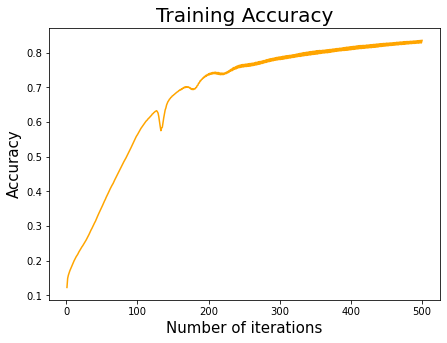

In [44]:
# Append to list
learning_rates.append(0.125)
accuracy.append(accuracy1[-1])

# Plot accuracy graph
print("Accuracy on Training Set: ", accuracy1[-1])
plot_accuracy(accuracy1,500)

### Learning rate = 0.15

In [46]:
# Learning rate of 0.15
W1,b1,W2,b2,W3,b3,accuracy1,predictions1=gradient_descent1(x_train,y_train,500,0.15)

0.8596585365853658


Accuracy on Training Set:  0.8596585365853658


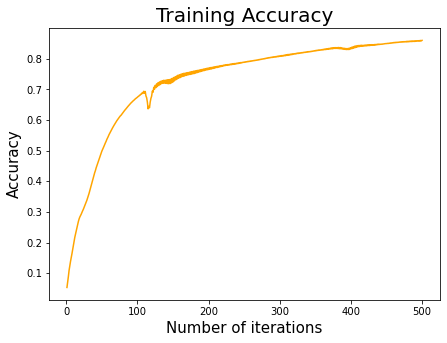

In [47]:
# Append to list
learning_rates.append(0.15)
accuracy.append(accuracy1[-1])

# Plot accuracy graph
print("Accuracy on Training Set: ", accuracy1[-1])
plot_accuracy(accuracy1,500)

### Learning rate = 0.175

In [48]:
# Learning rate of 0.175
W1,b1,W2,b2,W3,b3,accuracy1,predictions1=gradient_descent1(x_train,y_train,500,0.175)

Accuracy on Training Set:  0.8400975609756097


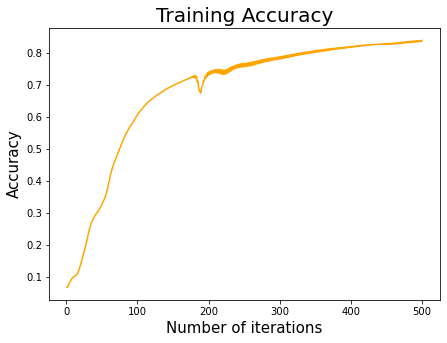

In [50]:
# Append to list
learning_rates.append(0.175)
accuracy.append(accuracy1[-1])

# Plot accuracy graph
print("Accuracy on Training Set: ", accuracy1[-1])
plot_accuracy(accuracy1,500)

#### A fall in accuracy suggests that we have passed the optimal learning rate and now the learning rate is too fast

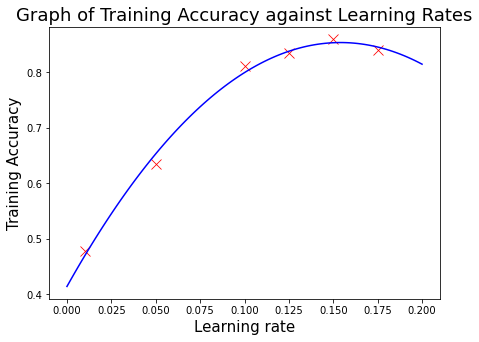

In [58]:
# Plot a best fit curve using regression technique
plt.figure(figsize=(7,5))
x=np.array(learning_rates)
y=np.array(accuracy)
coefficients=np.polyfit(x, y, deg=2)
polynomial=np.poly1d(coefficients)
x_range=np.linspace(0,0.2,100) # Generate a range of x values for plotting the curve
sb.scatterplot(x=x,y=y, marker='x', color='red',s=100)
sb.lineplot(x=x_range, y=polynomial(x_range), color='blue')

plt.xlabel('Learning rate',fontsize=15)
plt.ylabel('Training Accuracy',fontsize=15)
plt.title('Graph of Training Accuracy against Learning Rates',fontsize=18)
plt.show()

In [61]:
# Find learning rate with the highest training accuracy
max_index=np.argmax(polynomial(x_range))
max_x=x_range[max_index]
max_y=polynomial(max_x)
print("Maximum point coordinates: ("+str(max_x)+","+str(max_y)+")")

Maximum point coordinates: (0.15353535353535352,0.8539128783098373)


In [64]:
# Use this learning rate for kaggle test
W1,b1,W2,b2,W3,b3,accuracy1,predictions1=gradient_descent1(x_train,y_train,500,0.15353535353535352)

def kaggle_test(W1,b1,W2,b2,W3,b3):
    testset=pd.read_csv('test.csv')
    # Transpose the matrix such that each column is one image, and can be supplied to the input layer
    testset_x=testset.T/255. # Normalize the dataset

    # Get accuracy of model's predictions on new, unseen data
    testset_pred=make_predictions1(testset_x,W1,b1,W2,b2,W3,b3)
    
    # Create dataframe for submission on Kaggle
    imageid=[i+1 for i in range(28000)]
    data={'ImageId': imageid, 
          'Label': testset_pred.tolist()}
    final=pd.DataFrame(data)
    final.to_csv('submission.csv', index=False)
    
kaggle_test(W1,b1,W2,b2,W3,b3)

**Submission #2\
Accuracy: 0.8431**
#### An improvement from before! But let's not stop here, we are going to introduce some adjustments to improve our model further

## Configuration #1: Changing number of nodes

Now, let's try a (784-128-64-10) three-layer neural network. Varying the number of nodes in each layer allows the network to capture different aspects of the data and create a more effective hierachical representation

In [31]:
# Combine all functions into a single Dense Neural Network (DNN) class
class DNN:
    
    def __init__(self, epochs=100,lr=0.01):
        self.epochs=epochs
        self.lr=lr
        
        self.params={
            'W1': np.random.rand(128,784)-0.5, # 128x784
            'b1': np.random.rand(128,1)-0.5, 
            'W2': np.random.rand(64,128)-0.5, # 64x128
            'b2': np.random.rand(64,1)-0.5,
            'W3': np.random.rand(10,64)-0.5, # 10x64
            'b3': np.random.rand(10,1)-0.5
        }
        
        self.change={}
        
    def ReLU(self,Z):
        return np.maximum(Z,0)

    def softmax(self,Z):
        A = np.exp(Z) / sum(np.exp(Z))
        return A
    
    def deriv_ReLU(self,Z):
        return Z > 0
    
    def one_hot(self,Y):
        one_hot_Y=np.zeros((Y.size, Y.max()+1))
        one_hot_Y[np.arange(Y.size),Y]=1 # Match where the 1s are at
        one_hot_Y=one_hot_Y.T # Transpose to get each column as an example
        return one_hot_Y
    
    def forward_prop(self, X):
        params=self.params
        params['X']=X # 784x1, input layer
        
        params['Z1']=params['W1'].dot(params['X'])+params['b1']
        params['A1']=self.ReLU(params['Z1']) # First layer

        params['Z2']=params['W2'].dot(params['A1'])+params['b2']
        params['A2']=self.ReLU(params['Z2']) # Second layer

        params['Z3']=params['W3'].dot(params['A2'])+params['b3']
        params['A3']=self.softmax(params['Z3']) # Third layer
        
        return params['A3']

    def back_prop(self,Y,output):
        params=self.params
        params['Y']=self.one_hot(Y)
        
        m=len(Y)
        change=self.change

        dZ3=output-params['Y']
        change['W3']=1 / m * dZ3.dot(params['A2'].T)
        change['b3']=1 / m * np.sum(dZ3)
        
        dZ2=params['W3'].T.dot(dZ3) * self.deriv_ReLU(params['Z2'])
        change['W2']=1 / m * dZ2.dot(params['A1'].T)
        change['b2']=1 / m * np.sum(dZ2)
        
        dZ1=params['W2'].T.dot(dZ2) * self.deriv_ReLU(params['Z1'])
        change['W1']=1 / m * dZ1.dot(params['X'].T)
        change['b1']=1 / m * np.sum(dZ1)
        
        return change
    
    def update_params(self,change):
        params=self.params
        for key,val in change.items():
            params[key]-=self.lr*val
            
    def get_predictions(self,X):
        return np.argmax(X,0)
        
    def get_accuracy(self,predictions, Y):
        return np.sum(predictions==Y)/Y.size
     
    # continue with train function
    def train(self,X,Y):
        accuracy=[]
        change=self.change
        for i in range(1,self.epochs+1):
            output=self.forward_prop(X)
            change=self.back_prop(Y,output)
            self.update_params(self.change)
            accuracy.append(self.get_accuracy(self.get_predictions(output),Y))
            if i%50==0:
                print("Iteration: ",i)
                print("Accuracy: ", accuracy[-1])
        predictions=self.get_predictions(output)
        return accuracy,predictions
    
    def predict(self,X):
        output=self.forward_prop(X)
        predictions=self.get_predictions(output)
        return predictions
        
    

In [32]:
# Let's try with 500 epochs and learning rate 0.05
NN1=DNN(epochs=500,lr=0.05)
accuracy,predictions=NN1.train(x_train,y_train)

Iteration:  50
Accuracy:  0.6588048780487805
Iteration:  100
Accuracy:  0.7548048780487805
Iteration:  150
Accuracy:  0.7988536585365854
Iteration:  200
Accuracy:  0.8247560975609756
Iteration:  250
Accuracy:  0.8438292682926829
Iteration:  300
Accuracy:  0.8564634146341463
Iteration:  350
Accuracy:  0.8662926829268293
Iteration:  400
Accuracy:  0.8746585365853659
Iteration:  450
Accuracy:  0.8820243902439024
Iteration:  500
Accuracy:  0.8870487804878049


Accuracy on Training Set:  0.8870487804878049


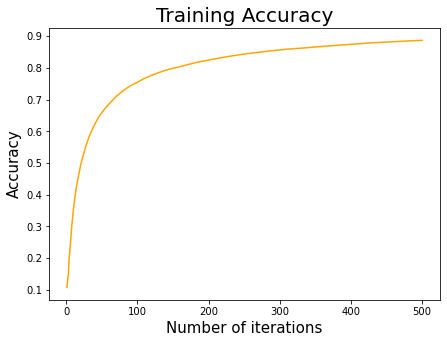

In [39]:
# Plot accuracy graph
print("Accuracy on Training Set: ", accuracy[-1])
plot_accuracy(accuracy,500)

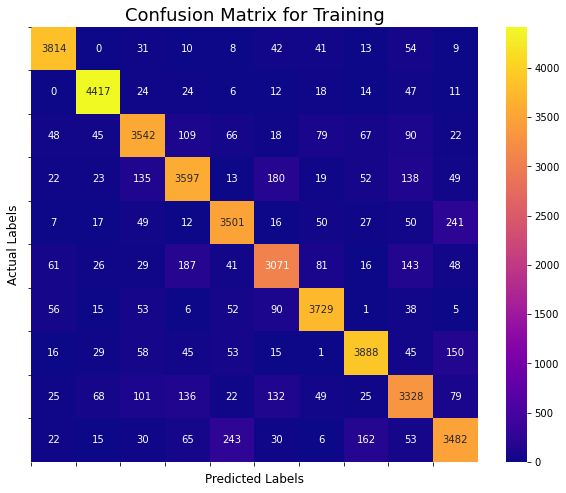

In [45]:
# Plot confusion matrix to illustrate results
plot_confusion(y_train,predictions)

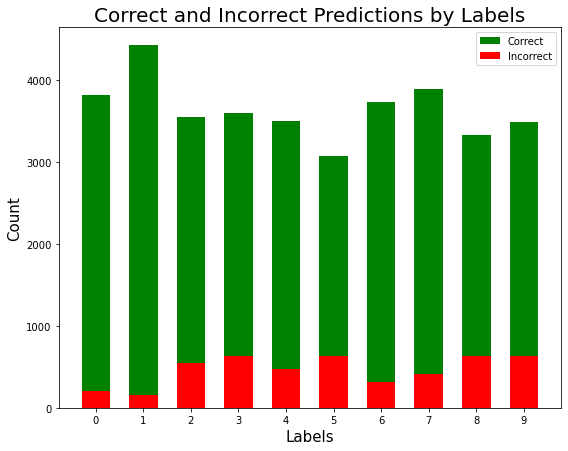

In [48]:
# Plot graph to see proportion of correct to incorrect predictions
plot_bar(y_train,predictions)

#### Training accuracy is much better than before and could even continue to increase if we increase the number of epochs but now let's try on the test dataset

In [49]:
# Testing on the test dataset
y_pred=NN1.predict(x_test)
print("Accuracy on Test Dataset: ", NN1.get_accuracy(y_pred,y_test))

Accuracy on Test Dataset:  0.897


In [50]:
# Feeding the Kaggle's testset to our model
testset=pd.read_csv('test.csv')

# Transpose the matrix such that each column is one image, and can be supplied to the input layer
testset_x=testset.T/255. # Normalize the dataset

# Get accuracy of model's predictions on new, unseen data
testset_pred=NN1.predict(testset_x)
    
# Create dataframe for submission on Kaggle
imageid=[i+1 for i in range(28000)]
data={'ImageId': imageid, 'Label': testset_pred.tolist()}
final=pd.DataFrame(data)
final.to_csv('submission.csv', index=False)


**Submission #3\
Accuracy: 0.88035\
Close to 0.04 increase! Looks like we are on the right track, let's try to get it above 0.90?**

In [56]:
# Save the NN model
with open('denseModel_ReLU(784-128-64-10).pkl','wb') as file:
    pickle.dump(NN1,file)

## Configuration #2: Trying a different activation function

Although the ReLU activation function is a common choice and has been proven to work well for digit classification, we can still try out other activation functions and assess their impact on model performance in order to determine the most suitable choice.

Here, we will try Exponential Linear Unit (ELU), a variant of ReLU. This activation function allows some activation for negative inputs, which addresses the issue of "dead neurons" in traditional ReLU. In traditional ReLU, negative inputs are converted to 0, resulting in a dead neuron that does not contribute to the network's learning

## Exponential Linear Unit (ELU) Activation Function

In [59]:
from IPython.display import Image

Image(url='ELU.png', width=400,height=300)

In [60]:
# Combine all functions into a single Dense Neural Network (DNN) class with ELU acitvation function
class DNN1:
    
    def __init__(self, epochs=100,lr=0.01):
        self.epochs=epochs
        self.lr=lr
        
        self.params={
            'W1': np.random.rand(128,784)-0.5, # 128x784
            'b1': np.random.rand(128,1)-0.5, 
            'W2': np.random.rand(64,128)-0.5, # 64x128
            'b2': np.random.rand(64,1)-0.5,
            'W3': np.random.rand(10,64)-0.5, # 10x64
            'b3': np.random.rand(10,1)-0.5
        }
        
        self.change={}
        
    def ELU(self,Z,alpha=1.0): # alpha is a hyperparameter that controls the saturation of the functions for negative inputs
        return np.where(Z>=0,Z,alpha*(np.exp(Z)-1)) # np.where checks whether condition Z>=0 is met

    def softmax(self,Z):
        A = np.exp(Z) / sum(np.exp(Z))
        return A
    
    def deriv_ELU(self,Z,alpha=1.0):
        return np.where(Z>=0,1,alpha*np.exp(Z))
    
    def one_hot(self,Y):
        one_hot_Y=np.zeros((Y.size, Y.max()+1))
        one_hot_Y[np.arange(Y.size),Y]=1 # Match where the 1s are at
        one_hot_Y=one_hot_Y.T # Transpose to get each column as an example
        return one_hot_Y
    
    def forward_prop(self, X):
        params=self.params
        params['X']=X # 784x1, input layer
        
        params['Z1']=params['W1'].dot(params['X'])+params['b1']
        params['A1']=self.ELU(params['Z1']) # First layer

        params['Z2']=params['W2'].dot(params['A1'])+params['b2']
        params['A2']=self.ELU(params['Z2']) # Second layer

        params['Z3']=params['W3'].dot(params['A2'])+params['b3']
        params['A3']=self.softmax(params['Z3']) # Third layer
        
        return params['A3']

    def back_prop(self,Y,output):
        params=self.params
        params['Y']=self.one_hot(Y)
        
        m=len(Y)
        change=self.change

        dZ3=output-params['Y']
        change['W3']=1 / m * dZ3.dot(params['A2'].T)
        change['b3']=1 / m * np.sum(dZ3)
        
        dZ2=params['W3'].T.dot(dZ3) * self.deriv_ELU(params['Z2'])
        change['W2']=1 / m * dZ2.dot(params['A1'].T)
        change['b2']=1 / m * np.sum(dZ2)
        
        dZ1=params['W2'].T.dot(dZ2) * self.deriv_ELU(params['Z1'])
        change['W1']=1 / m * dZ1.dot(params['X'].T)
        change['b1']=1 / m * np.sum(dZ1)
        
        return change
    
    def update_params(self,change):
        params=self.params
        for key,val in change.items():
            params[key]-=self.lr*val
            
    def get_predictions(self,X):
        return np.argmax(X,0)
        
    def get_accuracy(self,predictions, Y):
        return np.sum(predictions==Y)/Y.size
     
    # continue with train function
    def train(self,X,Y):
        accuracy=[]
        change=self.change
        for i in range(1,self.epochs+1):
            output=self.forward_prop(X)
            change=self.back_prop(Y,output)
            self.update_params(self.change)
            accuracy.append(self.get_accuracy(self.get_predictions(output),Y))
            if i%50==0:
                print("Iteration: ",i)
                print("Accuracy: ", accuracy[-1])
        predictions=self.get_predictions(output)
        return accuracy,predictions
    
    def predict(self,X):
        output=self.forward_prop(X)
        predictions=self.get_predictions(output)
        return predictions
       

In [64]:
# Let's try with 500 epochs and learning rate 0.05
NN2=DNN1(500,0.05)
accuracy,predictions=NN2.train(x_train,y_train)

Iteration:  50
Accuracy:  0.7328536585365854
Iteration:  100
Accuracy:  0.8000487804878049
Iteration:  150
Accuracy:  0.8306097560975609
Iteration:  200
Accuracy:  0.8495853658536585
Iteration:  250
Accuracy:  0.8635853658536585
Iteration:  300
Accuracy:  0.8736829268292683
Iteration:  350
Accuracy:  0.8812682926829268
Iteration:  400
Accuracy:  0.8881951219512195
Iteration:  450
Accuracy:  0.8943414634146342
Iteration:  500
Accuracy:  0.8978780487804878


Accuracy on Training Set:  0.8978780487804878


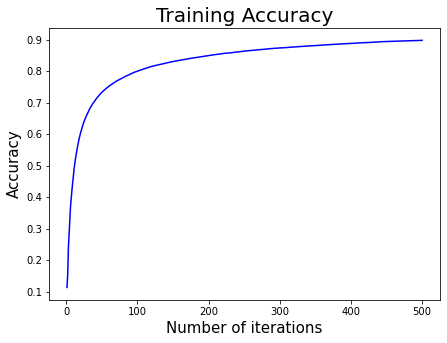

In [68]:
# Plot accuracy graph
print("Accuracy on Training Set: ", accuracy[-1])
plot_accuracy(accuracy,500)

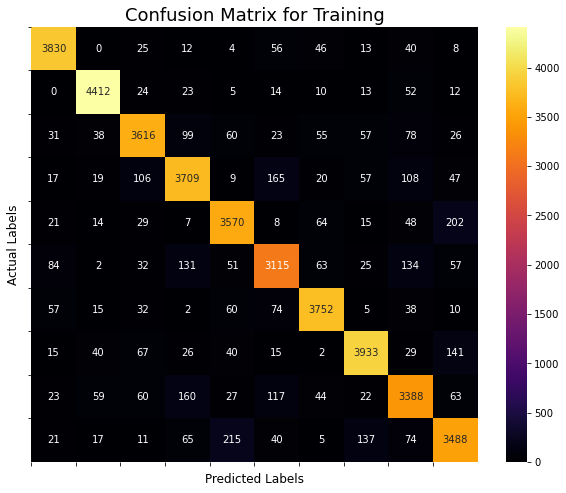

In [69]:
# Plot confusion matrix to illustrate results
plot_confusion(y_train,predictions)

In [72]:
# Save the NN model
with open('denseModel_ELU(784-128-64-10).pkl','wb') as file:
    pickle.dump(NN2,file)

In [70]:
# Testing on the test dataset
y_pred=NN2.predict(x_test)
print("Accuracy on Test Dataset: ", NN2.get_accuracy(y_pred,y_test))

Accuracy on Test Dataset:  0.882


Not that good for test dataset, could be due to overfitting which occurs when the model becomes too closely tailored to the training set. 

## Sigmoid Activation Function

In [71]:
Image(url='sigmoid.png', width=400,height=300)

In [73]:
# Combine all functions into a single Dense Neural Network (DNN) class with Sigmoid acitvation function
class DNN2:
    
    def __init__(self, epochs=100,lr=0.01):
        self.epochs=epochs
        self.lr=lr
        
        self.params={
            'W1': np.random.rand(128,784)-0.5, # 128x784
            'b1': np.random.rand(128,1)-0.5, 
            'W2': np.random.rand(64,128)-0.5, # 64x128
            'b2': np.random.rand(64,1)-0.5,
            'W3': np.random.rand(10,64)-0.5, # 10x64
            'b3': np.random.rand(10,1)-0.5
        }
        
        self.change={}
        
    def sigmoid(self,Z):
        return 1 / (1+np.exp(-Z))

    def softmax(self,Z):
        A = np.exp(Z) / sum(np.exp(Z))
        return A
    
    def deriv_sigmoid(self,Z):
        sigmoid_x=self.sigmoid(Z)
        return sigmoid_x*(1-sigmoid_x)
    
    def one_hot(self,Y):
        one_hot_Y=np.zeros((Y.size, Y.max()+1))
        one_hot_Y[np.arange(Y.size),Y]=1 # Match where the 1s are at
        one_hot_Y=one_hot_Y.T # Transpose to get each column as an example
        return one_hot_Y
    
    def forward_prop(self, X):
        params=self.params
        params['X']=X # 784x1, input layer
        
        params['Z1']=params['W1'].dot(params['X'])+params['b1']
        params['A1']=self.sigmoid(params['Z1']) # First layer

        params['Z2']=params['W2'].dot(params['A1'])+params['b2']
        params['A2']=self.sigmoid(params['Z2']) # Second layer

        params['Z3']=params['W3'].dot(params['A2'])+params['b3']
        params['A3']=self.softmax(params['Z3']) # Third layer
        
        return params['A3']

    def back_prop(self,Y,output):
        params=self.params
        params['Y']=self.one_hot(Y)
        
        m=len(Y)
        change=self.change

        dZ3=output-params['Y']
        change['W3']=1 / m * dZ3.dot(params['A2'].T)
        change['b3']=1 / m * np.sum(dZ3)
        
        dZ2=params['W3'].T.dot(dZ3) * self.deriv_sigmoid(params['Z2'])
        change['W2']=1 / m * dZ2.dot(params['A1'].T)
        change['b2']=1 / m * np.sum(dZ2)
        
        dZ1=params['W2'].T.dot(dZ2) * self.deriv_sigmoid(params['Z1'])
        change['W1']=1 / m * dZ1.dot(params['X'].T)
        change['b1']=1 / m * np.sum(dZ1)
        
        return change
    
    def update_params(self,change):
        params=self.params
        for key,val in change.items():
            params[key]-=self.lr*val
            
    def get_predictions(self,X):
        return np.argmax(X,0)
        
    def get_accuracy(self,predictions, Y):
        return np.sum(predictions==Y)/Y.size
     
    # continue with train function
    def train(self,X,Y):
        accuracy=[]
        change=self.change
        for i in range(1,self.epochs+1):
            output=self.forward_prop(X)
            change=self.back_prop(Y,output)
            self.update_params(self.change)
            accuracy.append(self.get_accuracy(self.get_predictions(output),Y))
            if i%50==0:
                print("Iteration: ",i)
                print("Accuracy: ", accuracy[-1])
        predictions=self.get_predictions(output)
        return accuracy,predictions
    
    def predict(self,X):
        output=self.forward_prop(X)
        predictions=self.get_predictions(output)
        return predictions
       

In [74]:
# Let's try with 500 epochs and learning rate 0.05
NN3=DNN2(500,0.05)
accuracy,predictions=NN3.train(x_train,y_train)

Iteration:  50
Accuracy:  0.2852195121951219
Iteration:  100
Accuracy:  0.4161951219512195
Iteration:  150
Accuracy:  0.5114390243902439
Iteration:  200
Accuracy:  0.5834390243902439
Iteration:  250
Accuracy:  0.6361951219512195
Iteration:  300
Accuracy:  0.6777073170731708
Iteration:  350
Accuracy:  0.7100243902439024
Iteration:  400
Accuracy:  0.7338292682926829
Iteration:  450
Accuracy:  0.7539268292682927
Iteration:  500
Accuracy:  0.769609756097561


Accuracy on Training Set:  0.769609756097561


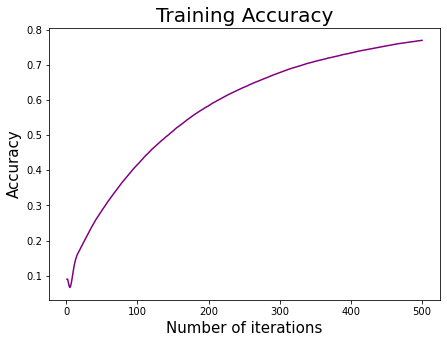

In [77]:
# Plot accuracy graph
print("Accuracy on Training Set: ", accuracy[-1])
plot_accuracy(accuracy,500)

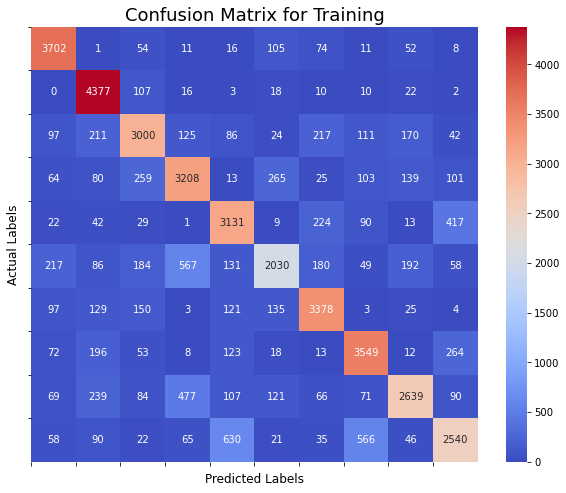

In [86]:
# Plot confusion matrix to illustrate results
plot_confusion(y_train,predictions)

In [87]:
# Testing on the test dataset
y_pred=NN3.predict(x_test)
print("Accuracy on Test Dataset: ", NN3.get_accuracy(y_pred,y_test))

Accuracy on Test Dataset:  0.767


Accuracy is much worse when sigmoid activation function is used. Possible reasons include

- Vanishing Gradient: Occurs when gradients become extremely small, leading to slow convergence during training
- Saturation problem: Happens when the outputs of an activation function become close to the extreme values of the function's range, like 0 or 1 for sigmoid activation. For extreme values, gradients are also extremely small, leading to the problem of vanishing gradient 

This also explains why sigmoid activation functions are not commonly used in the hidden layers of neural networks for digit classification. Hence, we will stick to ReLU for our choice of activation function.

## Configuration #3: Implementing Weights Initialization method

Weights initialization is important in training neural networks because it can significantly impact the learning dynamics and convergence of the network.

## Xavier Initialization

This method scales the inital weights using a Gaussian distribution with zero mean and a variance of 1/n, where n is the number of inputs to the ReLU layer. Xavier initialization works well with ReLU because it balances the variances of the inputs and outputs of the ReLU layer, helping to prevent the saturation of the ReLU units.  


In [11]:
# Define Xavier initialization function
def xavier_init(n_in, n_out):
    var=1.0/(n_in + n_out) # Calculate variance
    stdev=np.sqrt(var) # Calculate standard deviation
    weights=np.random.normal(loc=0.0,scale=stdev, size=(n_in,n_out)) # Generate random values from a Gaussian distribution with a mean of 0 and S.D of stdev
    return weights

# Combine all functions into a single Dense Neural Network (DNN) class with Xavier Initialization
class DNN3:
    
    def __init__(self, epochs=100,lr=0.01):
        self.epochs=epochs
        self.lr=lr
        
         # Initalization parameters with Xavier Initialization
        self.params={
            'W1': xavier_init(128,784), # 128x784
            'b1': xavier_init(128,1), # 128x1
            'W2': xavier_init(64,128), # 64x128
            'b2': xavier_init(64,1), # 64x1
            'W3': xavier_init(10,64), # 10x64
            'b3': xavier_init(10,1) #10x1
        }
        
        self.change={}
        
    def ReLU(self,Z):
        return np.maximum(Z,0)

    def softmax(self,Z):
        A = np.exp(Z) / sum(np.exp(Z))
        return A
    
    def deriv_ReLU(self,Z):
        return Z > 0
    
    def one_hot(self,Y):
        one_hot_Y=np.zeros((Y.size, Y.max()+1))
        one_hot_Y[np.arange(Y.size),Y]=1 # Match where the 1s are at
        one_hot_Y=one_hot_Y.T # Transpose to get each column as an example
        return one_hot_Y
    
    def forward_prop(self, X):
        params=self.params
        params['X']=X # 784x1, input layer
        
        params['Z1']=params['W1'].dot(params['X'])+params['b1']
        params['A1']=self.ReLU(params['Z1']) # First layer

        params['Z2']=params['W2'].dot(params['A1'])+params['b2']
        params['A2']=self.ReLU(params['Z2']) # Second layer

        params['Z3']=params['W3'].dot(params['A2'])+params['b3']
        params['A3']=self.softmax(params['Z3']) # Third layer
        
        return params['A3']

    def back_prop(self,Y,output):
        params=self.params
        params['Y']=self.one_hot(Y)
        
        m=len(Y)
        change=self.change

        dZ3=output-params['Y']
        change['W3']=1 / m * dZ3.dot(params['A2'].T)
        change['b3']=1 / m * np.sum(dZ3)
        
        dZ2=params['W3'].T.dot(dZ3) * self.deriv_ReLU(params['Z2'])
        change['W2']=1 / m * dZ2.dot(params['A1'].T)
        change['b2']=1 / m * np.sum(dZ2)
        
        dZ1=params['W2'].T.dot(dZ2) * self.deriv_ReLU(params['Z1'])
        change['W1']=1 / m * dZ1.dot(params['X'].T)
        change['b1']=1 / m * np.sum(dZ1)
        
        return change
    
    def update_params(self,change):
        params=self.params
        for key,val in change.items():
            params[key]-=self.lr*val
            
    def get_predictions(self,X):
        return np.argmax(X,0)
        
    def get_accuracy(self,predictions, Y):
        return np.sum(predictions==Y)/Y.size
     
    # continue with train function
    def train(self,X,Y):
        accuracy=[]
        change=self.change
        for i in range(1,self.epochs+1): # Repeat forward and backward propagation and updates weights and biases after each iteration
            output=self.forward_prop(X)
            change=self.back_prop(Y,output)
            self.update_params(self.change)
            accuracy.append(self.get_accuracy(self.get_predictions(output),Y))
            if i%50==0: 
                print("Iteration: ",i)
                print("Accuracy: ", accuracy[-1])
        predictions=self.get_predictions(output)
        return accuracy,predictions
    
    def predict(self,X):
        output=self.forward_prop(X)
        predictions=self.get_predictions(output)
        return predictions
        
    

In [12]:
# Let's try with 500 epochs and learning rate 0.05
NN4=DNN3(500,0.05)
accuracy,predictions=NN4.train(x_train,y_train)

Iteration:  50
Accuracy:  0.690390243902439
Iteration:  100
Accuracy:  0.8304390243902439
Iteration:  150
Accuracy:  0.8631463414634146
Iteration:  200
Accuracy:  0.8777317073170732
Iteration:  250
Accuracy:  0.8870243902439024
Iteration:  300
Accuracy:  0.8925365853658537
Iteration:  350
Accuracy:  0.8973170731707317
Iteration:  400
Accuracy:  0.9012682926829269
Iteration:  450
Accuracy:  0.9043414634146342
Iteration:  500
Accuracy:  0.9073414634146342


Accuracy on Training Set:  0.9073414634146342


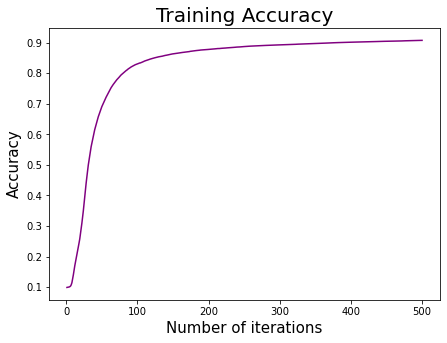

In [18]:
# Plot accuracy graph
print("Accuracy on Training Set: ", accuracy[-1])
plot_accuracy(accuracy,500)

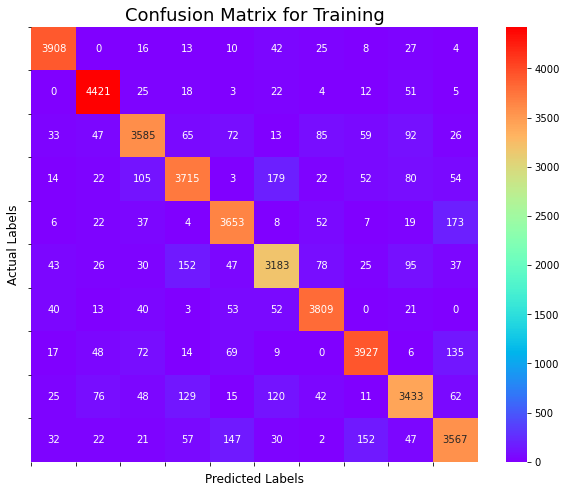

In [21]:
# Plot confusion matrix to illustrate results
plot_confusion(y_train,predictions)

In [23]:
# Testing on the test dataset
y_pred=NN4.predict(x_test)
print("Accuracy on Test Dataset: ", NN4.get_accuracy(y_pred,y_test))

Accuracy on Test Dataset:  0.895


In [25]:
# Save the NN model
with open('denseModel_Xavier(784-128-64-10).pkl','wb') as file:
    pickle.dump(NN4,file)

In [24]:
# Feeding the Kaggle's testset to our model
testset=pd.read_csv('test.csv')

# Transpose the matrix such that each column is one image, and can be supplied to the input layer
testset_x=testset.T/255. # Normalize the dataset

# Get accuracy of model's predictions on new, unseen data
testset_pred=NN4.predict(testset_x)
    
# Create dataframe for submission on Kaggle
imageid=[i+1 for i in range(28000)]
data={'ImageId': imageid, 'Label': testset_pred.tolist()}
final=pd.DataFrame(data)
final.to_csv('submission.csv', index=False)


**Submission #4\
Accuracy: 0.9046\
First time over 90%!!**

Thank you for reading until the end of this notebook. This notebook focuses on building Dense Neural Network (Fully-connect networks) from scratch and I hope you found this notebook helpful and insightful. Subsequently, I am attempting to build Convolutional Neural networks (CNNs) from scratch with numpy for the same MNIST dataset. CNNs are often considered better than dense neural networks for digit classification due to the following reasons:

1. Local connectivity and parameter sharing: CNNs leverage the concept of local connectivity and parameter sharing, which allows them to focus on local patterns and share weights across different spatial locations. In digit classification, local patterns like edges, corners, and textures are crucial for distinguishing between different digits. CNNs excel at capturing these local features efficiently, whereas dense neural networks do not consider the spatial structure of the input data and treat each pixel as independent. The local connectivity and parameter sharing of CNNs make them more effective in learning and detecting relevant features in digit images.

2. Translation invariance: CNNs possess translation invariance, meaning they can recognize patterns regardless of their position in the input image. In digit classification, digits can appear at different locations within the image, and CNNs are capable of recognizing them irrespective of their position. On the other hand, dense neural networks are sensitive to the exact positioning of the input, requiring explicit spatial information or additional preprocessing steps to achieve translation invariance.